## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

In this homework, I will use the CMU movie plot summary dataset. By analyzing clusters using this dataset I want to see if there is any semantic patterns in different movie genres. Detailed explanation of the codes is presented as notes in different cells. 

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

In [2]:
movieDF = pandas.DataFrame(columns = ["plot summary"])

#Load movie plot data to a dataframe
with open("../week-6/MovieSummaries/plot_summaries.txt") as f:
    for line in f:
        movieDF = movieDF.append({"plot summary": line}, ignore_index = True)

In [3]:
movieDF["movie index"] = ""

In [4]:
for index, row in movieDF.iterrows():
    temp = row["plot summary"].split("\t")
    row["movie index"] = temp[0]
    row["plot summary"] = temp[1]

In [5]:
#Load movie summary data to a dataframe
colnames = ["movie index", "imdb index", "movie name", "release data", "revenue", "runtime", "language", "country", "genre"]
summaryDF = pandas.read_csv("../week-6/MovieSummaries/movie.metadata.tsv", sep='\t', names=colnames, header=None)

In [6]:
movieDF["movie index"] = movieDF["movie index"].astype(np.int64)

In [7]:
#Merge these two datasets
movieGenreDF = pandas.merge(movieDF, summaryDF, on="movie index", how="left")
movieGenreDF

,plot summary,movie index,imdb index,movie name,release data,revenue,runtime,language,country,genre
0,"Shlykov, a hard-working taxi driver and Lyosha...",23890098,/m/076w2lb,Taxi Blues,1990-09-07,NaN,110.0,"{""/m/06b_j"": ""Russian Language""}","{""/m/0f8l9c"": ""France"", ""/m/05vz3zq"": ""Soviet ...","{""/m/07s9rl0"": ""Drama"", ""/m/03q4nz"": ""World ci..."
1,The nation of Panem consists of a wealthy Capi...,31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/03btsm8"": ""Action/Adventure"", ""/m/06n90"":..."
2,Poovalli Induchoodan is sentenced for six yea...,20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/04t36"": ""Musical"", ""/m/02kdv5l"": ""Action""..."
3,"The Lemon Drop Kid , a New York City swindler,...",2231378,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06qm3"": ""Screwball comedy"", ""/m/01z4y"": ""..."
4,Seventh-day Adventist Church pastor Michael Ch...,595909,/m/02tqm5,A Cry in the Dark,1988-11-03,6908797.0,121.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
...,...,...,...,...,...,...,...,...,...,...
42301,"The story is about Reema , a young Muslim scho...",34808485,/m/0j3dcl6,Oomakkuyil Padumbol,2012-02-17,NaN,NaN,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","{""/m/0bj8m2"": ""Children's""}"
42302,"In 1928 Hollywood, director Leo Andreyev look...",1096473,/m/045pct,The Last Command,1928,NaN,88.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/06ppq"": ""Silent film"", ""/m/0219x_"": ""Indi..."
42303,American Luthier focuses on Randy Parsons’ tra...,35102018,/m/0j6777g,Randy Parsons: American Luthier,2011-10-04,NaN,8.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/04rlf"": ""Music..."
42304,"Abdur Rehman Khan , a middle-aged dry fruit se...",8628195,/m/04f7jfs,Kabuliwala,1961-12-14,NaN,134.0,"{""/m/03k50"": ""Hindi Language""}","{""/m/03rk0"": ""India""}","{""/m/07s9rl0"": ""Drama""}"


In [11]:
#Drop those rows with genre type missing
movieGenreDF = movieGenreDF.dropna(subset=['genre'])

In [43]:
#For the simplicity of analysis, only leave those movie that are "Thriller", "Documentary", and "Romance Film"
movieFinalDF = pandas.DataFrame(columns = ["movie index", "genre", "plot summary"])

for index, row in movieGenreDF.iterrows():
    genre = row["genre"]
    
    if "Thriller" in genre:
        movieFinalDF = movieFinalDF.append({"movie index": row["movie index"], "genre": "Thriller", "plot summary": row["plot summary"]}, ignore_index=True)
        continue
    if "Documentary" in genre:
        movieFinalDF = movieFinalDF.append({"movie index": row["movie index"], "genre": "Documentary", "plot summary": row["plot summary"]}, ignore_index=True)
        continue
    if "Romance Film" in genre:
        movieFinalDF = movieFinalDF.append({"movie index": row["movie index"], "genre": "Romance Film", "plot summary": row["plot summary"]}, ignore_index=True)
        continue

In [44]:
#Let us look at the final dataframe
movieFinalDF

,movie index,genre,plot summary
0,5272176,Thriller,The president is on his way to give a speech. ...
1,1952976,Thriller,"{{plot}} The film opens in 1974, as a young gi..."
2,2462689,Romance Film,Infuriated at being told to write one final co...
3,15072401,Thriller,"Alan Colby, heir to a vast fortune, reappears ..."
4,4596602,Thriller,"Ashes to Ashes is set in London, England. The ..."
...,...,...,...
14088,1585815,Thriller,The first half of the film is told in a non-co...
14089,677389,Romance Film,Dr. Sullivan Travis is a wealthy Dallas gyne...
14090,871575,Thriller,"{{Plot}} In an alternate universe, people are..."
14091,30352708,Romance Film,Twenty-something Eun-mo listens to a taxi driv...


In [45]:
#Now we initialize the data
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
movieVects = ngCountVectorizer.fit_transform(movieFinalDF['plot summary'])
print(movieVects.shape)

(14093, 79177)


In [46]:
#Now tf-idf measure
#initialize
movieTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(movieVects)
#train
movieTF = movieTFTransformer.transform(movieVects)
print(movieTF.shape)

(14093, 79177)


In [47]:
#Now prune our word vector
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
movieTFVects = ngTFVectorizer.fit_transform(movieFinalDF['plot summary'])

Now evaluate those categories using k-means

In [48]:
numClusters = len(set(movieFinalDF['genre']))
numClusters

3

In [49]:
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(movieTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [50]:
#And we look at the scores of this clustering
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(movieFinalDF['genre'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(movieFinalDF['genre'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(movieFinalDF['genre'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(movieFinalDF['genre'], km.labels_)))

The available metrics are: ['SCORERS', 'accuracy_score', 'adjusted_mutual_info_score', 'adjusted_rand_score', 'auc', 'average_precision_score', 'balanced_accuracy_score', 'base', 'brier_score_loss', 'calinski_harabasz_score', 'calinski_harabaz_score', 'check_scoring', 'classification', 'classification_report', 'cluster', 'cohen_kappa_score', 'completeness_score', 'confusion_matrix', 'consensus_score', 'coverage_error', 'davies_bouldin_score', 'euclidean_distances', 'explained_variance_score', 'f1_score', 'fbeta_score', 'fowlkes_mallows_score', 'get_scorer', 'hamming_loss', 'hinge_loss', 'homogeneity_completeness_v_measure', 'homogeneity_score', 'jaccard_score', 'jaccard_similarity_score', 'label_ranking_average_precision_score', 'label_ranking_loss', 'log_loss', 'make_scorer', 'matthews_corrcoef', 'max_error', 'mean_absolute_error', 'mean_squared_error', 'mean_squared_log_error', 'median_absolute_error', 'multilabel_confusion_matrix', 'mutual_info_score', 'normalized_mutual_info_score'

From the scores above we can see that the scores are not satisfying at all. The categorization is similar to random labelling. 

In [51]:
#Now look at the distinguishing features in each cluster
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 film
 documentary
 story
 cite
 life
 web
 world
 people
 follows
 love


Cluster 1:
 love
 father
 family
 mother
 life
 man
 daughter
 home
 son
 marriage


Cluster 2:
 police
 man
 new
 wife
 killed
 murder
 finds
 woman
 life
 death




By looking at the high frequency words appearing in each cluster, we can see that there is indeed some distinct patterns in each cluster. For example, we can easily distinguish that Cluster 0 is documentary genre, as it contains words such as "life", "world", and "documentary" itself. And Cluster 2 is apparently related to thriller films, as it contains features such as "police", "killed", and "murder". 

In [52]:
#Now plot it
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(movieTFVects.toarray())
reduced_data = pca.transform(movieTFVects.toarray())

In [54]:
colordict = {
'Thriller': 'blue',
'Romance Film': 'red',
'Documentary': 'green',
    }
colors = [colordict[c] for c in movieFinalDF['genre']]
print("The categories' colors are:\n{}".format(colordict.items()))

The categories' colors are:
dict_items([('Thriller', 'blue'), ('Romance Film', 'red'), ('Documentary', 'green')])


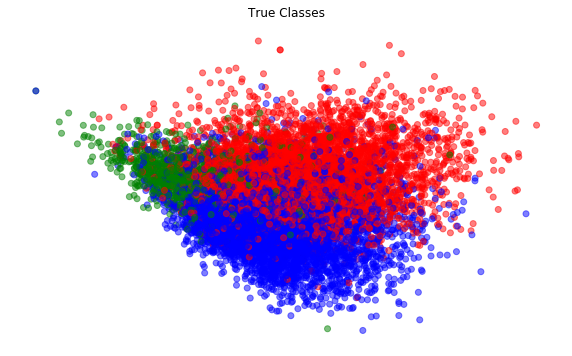

In [55]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

In [56]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

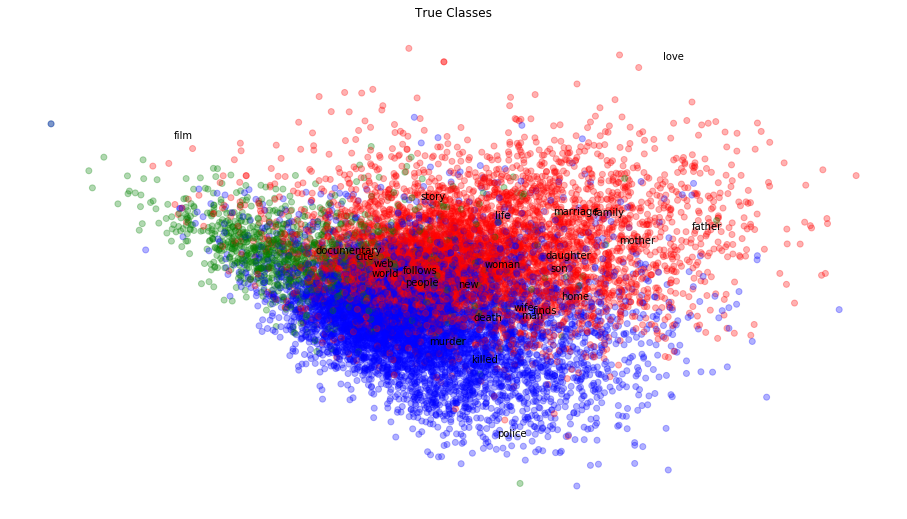

In [57]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

As we ca see, the feature words are more likely to appear at the border of the graph.

In [58]:
#Now let us look at predicted clusters
movieCategories = ['Thriller', 'Documentary', 'Romance Film']
colors_p = [colordict[movieCategories[l]] for l in km.labels_]

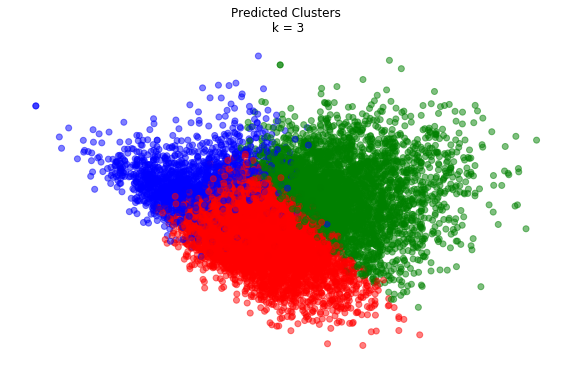

In [60]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 3')
plt.show()

In [61]:
#Now let us test what is the best number of clusters
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


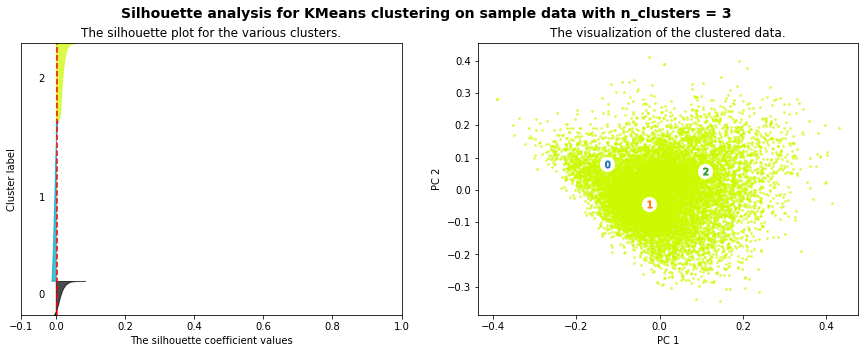

For n_clusters = 3, The average silhouette_score is : 0.005


In [62]:
#The original categories
X = movieTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


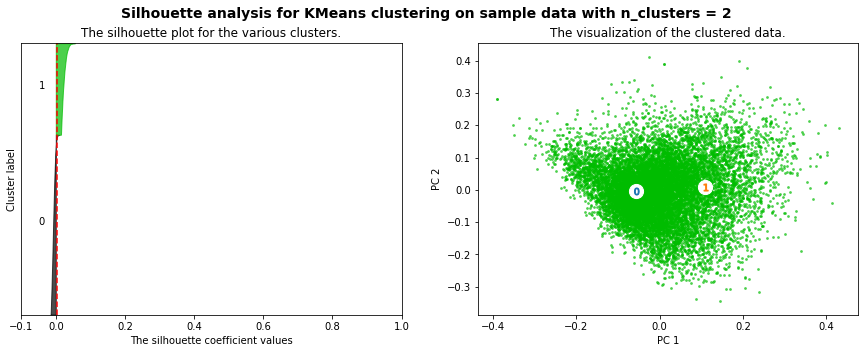

For n_clusters = 2, The average silhouette_score is : 0.003


In [63]:
#If the number of clusters = 2
X = movieTFVects.toarray()
plotSilhouette(2, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


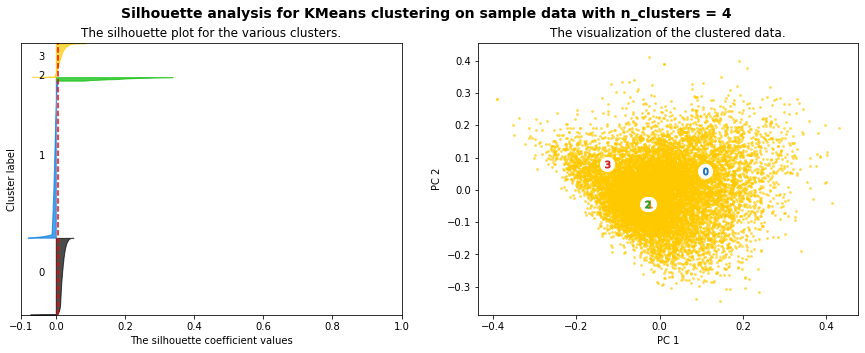

For n_clusters = 4, The average silhouette_score is : 0.006


In [64]:
#If the number of clusters = 3
X = movieTFVects.toarray()
plotSilhouette(4, X)

Based on Silhouette score, the corpora is better categorized into 4 different clusters. But as the last graph shows that, two of the clusters seem to be very closely connected to each other.

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

The first approach to construct hierarchical cluster:

In [65]:
movieTFVects

<14093x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 799351 stored elements in Compressed Sparse Row format>

In [66]:
movieTFVects[:100].todense()

matrix([[0.        , 0.        , 0.03096315, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.05716363, 0.        , ..., 0.        , 0.03272885,
         0.        ],
        [0.06130887, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.1093608 , 0.        , 0.        , ..., 0.        , 0.06389958,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [67]:
movieCoocMat = movieTFVects * movieTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
movieCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accura

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [68]:
selectIndices = []
indexToCat = []
for c in set(movieFinalDF['genre']):
    selectIndices += list(movieFinalDF[movieFinalDF['genre'] == c].index)[:50]
    indexToCat += [c] * 50

In [69]:
subCoocMat = movieCoocMat[selectIndices,:][:,selectIndices]

In [70]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 23.        , 115.        ,   0.28349296,   2.        ],
       [ 19.        , 149.        ,   0.33629188,   2.        ],
       [150.        , 151.        ,   0.36156886,   4.        ],
       [119.        , 127.        ,   0.38005223,   2.        ],
       [ 17.        , 152.        ,   0.3891696 ,   5.        ],
       [ 29.        , 132.        ,   0.40408575,   2.        ],
       [ 39.        , 105.        ,   0.40563307,   2.        ],
       [153.        , 154.        ,   0.41960783,   7.        ],
       [ 66.        , 156.        ,   0.42213682,   3.        ],
       [109.        , 157.        ,   0.44380028,   8.        ]])

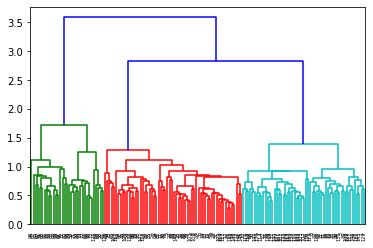

In [71]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

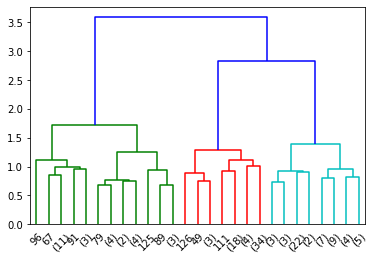

In [72]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

The second way to construct hierarchical cluster:

In [74]:
#If I cluster the corpora using original categories:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 3, 'maxclust')
hierarchicalClusters

array([2, 3, 2, 3, 2, 2, 2, 3, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 2, 2, 2, 3,
       3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 2, 2,
       3, 2, 3, 2, 2, 2, 3, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1,
       3, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2, 2, 3, 3, 2,
       3, 2, 3, 3, 3, 2, 3, 2, 3, 2, 3, 3, 3, 2, 3, 1, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2], dtype=int32)

In [75]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(movieCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 3, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(movieFinalDF['genre'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.022
Completeness: 0.026
V-measure: 0.024
Adjusted Rand Score: -0.016


In [76]:
#If I cluster the corpora using optimal categories suggested by Silhouette score:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([3, 4, 3, 4, 3, 3, 3, 4, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4,
       4, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 3, 3, 3, 4, 3, 3, 3,
       4, 3, 4, 3, 3, 3, 4, 1, 3, 2, 3, 1, 2, 3, 1, 2, 2, 2, 2, 2, 1, 3,
       3, 1, 1, 3, 2, 2, 1, 1, 2, 2, 3, 2, 3, 2, 1, 1, 3, 1, 2, 3, 1, 1,
       4, 2, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 4, 4, 3,
       4, 3, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 3, 4, 2, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 3, 4, 4, 3, 3, 4, 4, 3, 4, 4, 4, 3], dtype=int32)

In [77]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(movieCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(movieFinalDF['genre'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(movieFinalDF['genre'], hierarchicalClusters_full)))

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For our complete clusters:
Homogeneity: 0.036
Completeness: 0.026
V-measure: 0.030
Adjusted Rand Score: -0.003


Given the graphs above we can see that one of the clusters is completely different with another two at the very beginning. Based on our former analysis and experience, the cluster might be documentary films. 
When using hierarchical clustering, the metric score performs even worse than k-means method. The adjusted Rand score in hierarchical clustering is even less than 0. Looking at the plot graphs constructed in the former exercise, we can see that the three graphs approximately has the same "center", which implies there exist some films that has the features of all three clusters. So it is difficult, and even harder to cluster using hierarchical methods. 

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [78]:
#Normalize the data
movieFinalDF['tokenized_text'] = movieFinalDF['plot summary'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
movieFinalDF['normalized_tokens'] = movieFinalDF['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [87]:
#Divide the dataset in half by training and testing.
movieTraining = movieFinalDF[:7000]
movieTesting = movieFinalDF[7000:]

In [88]:
movieTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
movieTFVects = movieTFVectorizer.fit_transform(movieFinalDF['plot summary'])

In [89]:
#Drop Missing ones
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

movieTraining['reduced_tokens'] = movieTraining['normalized_tokens'].apply(lambda x: dropMissing(x, movieTFVectorizer.vocabulary_.keys()))

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [90]:
dictionary = gensim.corpora.Dictionary(movieTraining['reduced_tokens'])

In [91]:
corpus = [dictionary.doc2bow(text) for text in movieTraining['reduced_tokens']]

In [95]:
gensim.corpora.MmCorpus.serialize('movie.mm', corpus)
moviemm = gensim.corpora.MmCorpus('movie.mm')

In [96]:
#If we suppose there are 3 different topics in this corporus, just as the genre types
movielda = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, alpha='auto', eta='auto')

In [97]:
mov1Bow = dictionary.doc2bow(movieTraining['reduced_tokens'][10])
mov1lda = movielda[mov1Bow]

name = movieGenreDF.loc[movieGenreDF["movie index"] == movieTraining['movie index'][10], 'movie name'].iloc[0]
print("The topic of the text: {}".format(name))
print("are: {}".format(mov1lda))

The topic of the text: Eastern Promises
are: [(0, 0.98827416)]


In [101]:
movieTraining["movie name"] = ""
for index, row in movieTraining.iterrows():
    row["movie name"] = movieGenreDF.loc[movieGenreDF["movie index"] == row['movie index'], 'movie name'].iloc[0]

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
movieTraining

,movie index,genre,plot summary,tokenized_text,normalized_tokens,reduced_tokens,movie name
0,5272176,Thriller,The president is on his way to give a speech. ...,"[The, president, is, on, his, way, to, give, a...","[president, way, speech, travel, man, show, ca...","[shooter, crawford, investigative, bush, dive,...",End Game
1,1952976,Thriller,"{{plot}} The film opens in 1974, as a young gi...","[plot, The, film, opens, in, 1974, as, a, youn...","[plot, film, open, young, girl, dahlia, stand,...","[dahlia, flash, dahlia, midst, mediation, kyle...",Dark Water
2,2462689,Romance Film,Infuriated at being told to write one final co...,"[Infuriated, at, being, told, to, write, one, ...","[infuriate, tell, write, final, column, lay, n...","[infuriate, column, lay, mitchell, print, unem...",Meet John Doe
3,15072401,Thriller,"Alan Colby, heir to a vast fortune, reappears ...","[Alan, Colby, heir, to, a, vast, fortune, reap...","[alan, colby, heir, vast, fortune, reappear, y...","[alan, colby, vast, reappear, inheritance, col...",Charlie Chan's Secret
4,4596602,Thriller,"Ashes to Ashes is set in London, England. The ...","[Ashes, to, Ashes, is, set, in, London, Englan...","[ash, ash, set, london, england, film, surreal...","[ash, ash, surreal, misadventure, gabriel, scr...",Ashes to Ashes
...,...,...,...,...,...,...,...
6995,2670153,Documentary,"As a child summer means playing outside, lots ...","[As, a, child, summer, means, playing, outside...","[child, summer, mean, play, outside, lot, time...","[bike, translate, athletic, bike, sport, athle...",Wildflower: The Legendary California Triathlon
6996,7369863,Thriller,The film opens in a bar in Nunavut when hitman...,"[The, film, opens, in, a, bar, in, Nunavut, wh...","[film, open, bar, nunavut, hitman, brand, haus...","[brand, hauser, garbage, hauser, navigation, t...",War Inc.
6997,4213183,Romance Film,Anita is an American actress who decides to v...,"[Anita, is, an, American, actress, who, decide...","[anita, american, actress, decide, vacation, r...","[anita, involve]",Lovers and Liars
6998,1494502,Thriller,"{{plot}} In 2056 AD, Earth is in ecologic cris...","[plot, In, 2056, AD, Earth, is, in, ecologic, ...","[plot, ad, earth, ecologic, crisis, consequenc...","[ad, consequence, pollution, overpopulation, w...",Red Planet


In [103]:
ldaDF = pandas.DataFrame({
        'name' : movieTraining["movie name"],
        'topics' : [movielda[dictionary.doc2bow(l)] for l in movieTraining['reduced_tokens']]
    })

In [106]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(movielda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2
1,Dark Water,"[(0, 0.7052198), (1, 0.2907237)]",0.705220,0.290724,0.000000
101,Undercover Christmas,"[(0, 0.9445751), (1, 0.029936077), (2, 0.02548...",0.944575,0.029936,0.025489
201,Bumper Offer,"[(0, 0.9790354), (1, 0.010906832), (2, 0.01005...",0.979035,0.010907,0.010058
301,The Thrill of It All,"[(0, 0.035786178), (1, 0.9358548), (2, 0.02835...",0.035786,0.935855,0.028359
401,"All's Well, Ends Well 2009","[(0, 0.016906306), (1, 0.029083036), (2, 0.954...",0.016906,0.029083,0.954011
...,...,...,...,...,...
6501,Candy,"[(0, 0.3355094), (1, 0.55943006), (2, 0.105060...",0.335509,0.559430,0.105061
6601,Alibaba Aur 40 Chor,"[(0, 0.74889225), (1, 0.24631438)]",0.748892,0.246314,0.000000
6701,Mad About Men,"[(0, 0.26408353), (1, 0.010709282), (2, 0.7252...",0.264084,0.010709,0.725207
6801,Out for a Kill,"[(0, 0.15209095), (1, 0.13264789), (2, 0.71526...",0.152091,0.132648,0.715261


In [108]:
#Now let us visualize the first 15 movies in the corpus
ldaDFV = ldaDF[:15][['topic_%d' %x for x in range(3)]]
ldaDFVisN = ldaDF[:15][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2
0,0.954394,0.026031,0.019574
1,0.705220,0.290724,0.000000
2,0.133487,0.697594,0.168919
3,0.018621,0.966357,0.015022
4,0.214273,0.490265,0.295462
5,0.583702,0.056186,0.360112
6,0.068961,0.914058,0.016981
7,0.371346,0.615810,0.012845
8,0.779134,0.213978,0.000000
9,0.116930,0.391687,0.491382


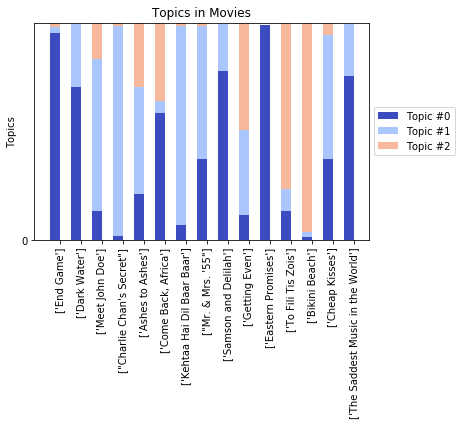

In [111]:
N = 15
ind = np.arange(N)
K = movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Movies')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

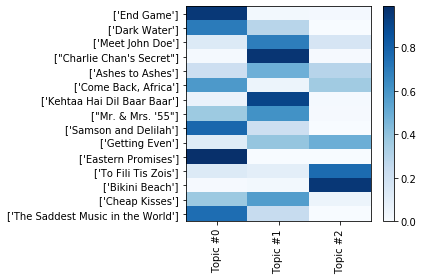

In [112]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [109]:
#Show the top 10 words in each topic
topicsDict = {}
for topicNum in range(movielda.num_topics):
    topicWords = [w for w, p in movielda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2
0,parent,wed,sophie
1,stanley,parent,parent
2,involve,maggie,sean
3,leo,jenny,ho
4,wed,involve,lucy
5,viktor,raj,abby
6,crow,crow,wed
7,vampire,vijay,gwen
8,tracy,samantha,involve
9,unite,sonia,suggest


<Figure size 432x288 with 0 Axes>

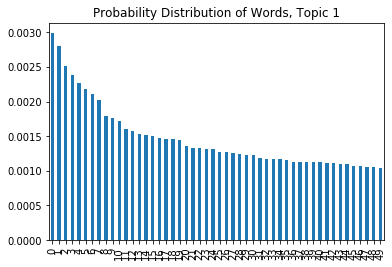

In [113]:
topic1_df = pandas.DataFrame(movielda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

<Figure size 432x288 with 0 Axes>

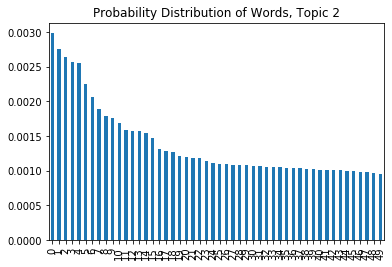

In [114]:
topic2_df = pandas.DataFrame(movielda.show_topic(2, topn=50))
plt.figure()
topic2_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 2')
plt.show()

<Figure size 432x288 with 0 Axes>

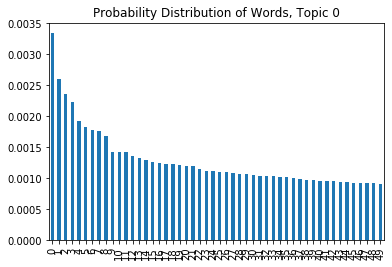

In [116]:
topic0_df = pandas.DataFrame(movielda.show_topic(0, topn=50))
plt.figure()
topic0_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 0')
plt.show()

In [124]:
movielda1 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.00001)
movielda2 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.01)
movielda3 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.5)
movielda4 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, eta = 0.9)

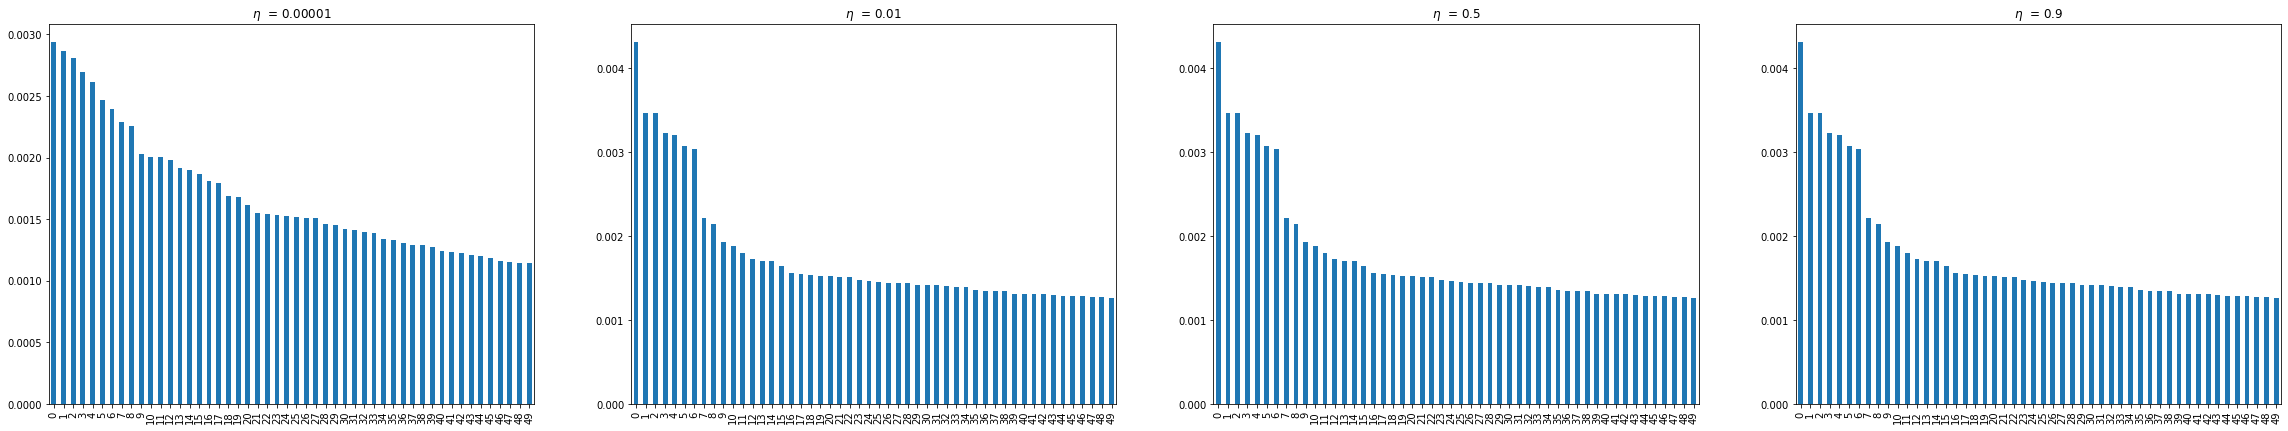

In [125]:
#Changing the value of eta
topic11_df = pandas.DataFrame(movielda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))
topic31_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))
topic41_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(40, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.01')
topic31_df.plot.bar(legend = False, ax = ax3, title = '$\eta$  = 0.5')
topic41_df.plot.bar(legend = False, ax = ax4, title = '$\eta$  = 0.9')
plt.show()

If we increase the value of eta, based on the four graphs above we can see that the distribution becomes more skewed in the head and in the tail. More specifically, the probability of high-frequency words increases and becomes more "pointy"; the probability of low-frequency words decrease and becomes more "flat. "

In [126]:
#Changing alpha values
movielda1 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, alpha = 0.001)
movielda2 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, alpha = 0.25)
movielda3 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, alpha = 0.5)
movielda4 = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=3, alpha = 0.9)

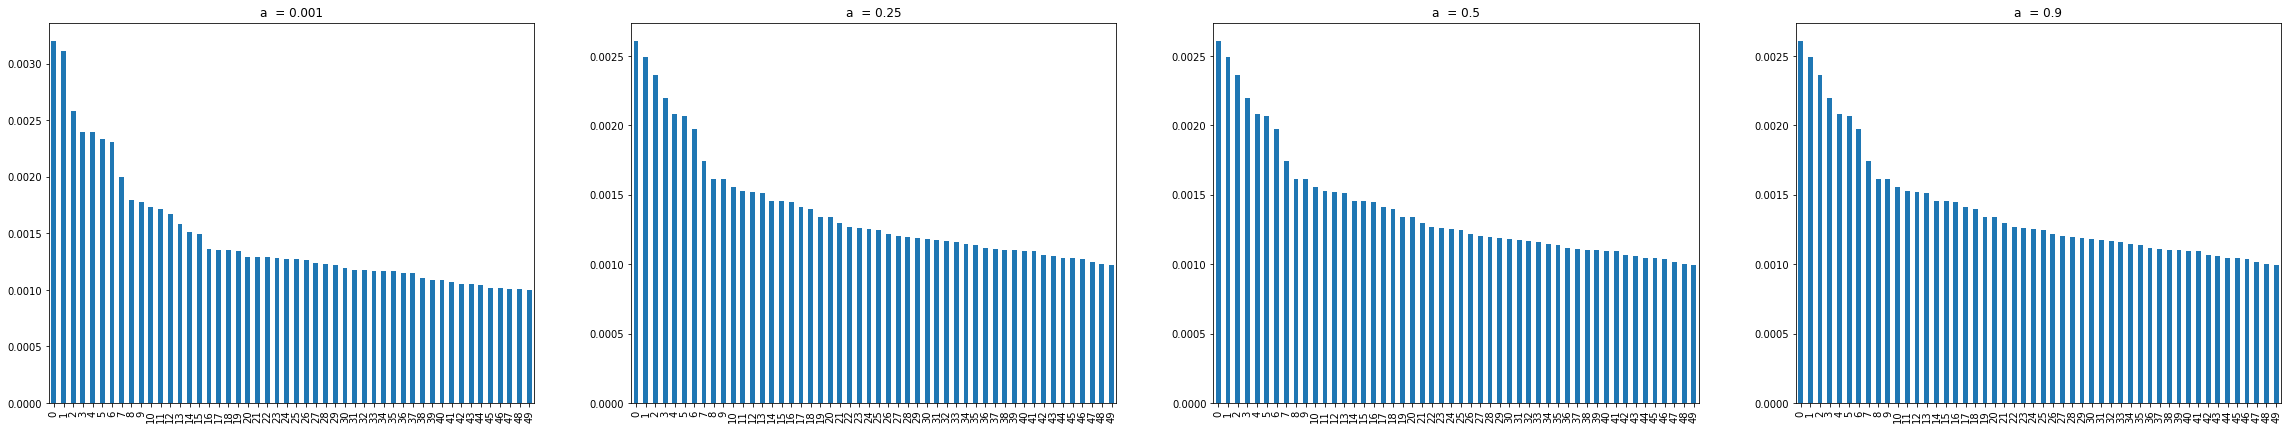

In [128]:
topic11_df = pandas.DataFrame(movielda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))
topic31_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))
topic41_df = pandas.DataFrame(movielda2.show_topic(1, topn=50))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig.set_size_inches(40, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = 'a  = 0.001')
topic21_df.plot.bar(legend = False, ax = ax2, title = 'a  = 0.25')
topic31_df.plot.bar(legend = False, ax = ax3, title = 'a  = 0.5')
topic41_df.plot.bar(legend = False, ax = ax4, title = 'a  = 0.9')
plt.show()

As we can see, if we increase the value of alpha, the difference between high-probability words and low-probability words decreases. In other words, the distribution becomes more smooth in this way. 

If there are 4 topics in this movie genre corpus...

In [129]:
#If we suppose there are 4 different topics in this corporus, just as the genre types
movielda = gensim.models.ldamodel.LdaModel(corpus=moviemm, id2word=dictionary, num_topics=4, alpha='auto', eta='auto')

In [130]:
mov1Bow = dictionary.doc2bow(movieTraining['reduced_tokens'][10])
mov1lda = movielda[mov1Bow]

name = movieGenreDF.loc[movieGenreDF["movie index"] == movieTraining['movie index'][10], 'movie name'].iloc[0]
print("The topic of the text: {}".format(name))
print("are: {}".format(mov1lda))

The topic of the text: Eastern Promises
are: [(2, 0.99071777)]


In [131]:
ldaDF = pandas.DataFrame({
        'name' : movieTraining["movie name"],
        'topics' : [movielda[dictionary.doc2bow(l)] for l in movieTraining['reduced_tokens']]
    })

In [132]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(movielda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(movielda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3
1,Dark Water,"[(0, 0.52736783), (3, 0.46797812)]",0.527368,0.000000,0.000000,0.467978
101,Undercover Christmas,"[(0, 0.013878109), (1, 0.014710535), (2, 0.016...",0.013878,0.014711,0.016651,0.954760
201,Bumper Offer,"[(0, 0.9805184)]",0.980518,0.000000,0.000000,0.000000
301,The Thrill of It All,"[(0, 0.01268108), (1, 0.014090606), (2, 0.0168...",0.012681,0.014091,0.016860,0.956368
401,"All's Well, Ends Well 2009","[(3, 0.9753439)]",0.000000,0.000000,0.000000,0.975344
...,...,...,...,...,...,...
6501,Candy,"[(0, 0.2875264), (1, 0.70138794)]",0.287526,0.701388,0.000000,0.000000
6601,Alibaba Aur 40 Chor,"[(2, 0.99124676)]",0.000000,0.000000,0.991247,0.000000
6701,Mad About Men,"[(0, 0.51052225), (1, 0.31636384), (2, 0.166964)]",0.510522,0.316364,0.166964,0.000000
6801,Out for a Kill,"[(0, 0.21913457), (1, 0.23558284), (2, 0.09816...",0.219135,0.235583,0.098166,0.447117


In [137]:
#Now let us visualize the first 15 movies in the corpus
ldaDFV = ldaDF[:15][['topic_%d' %x for x in range(4)]]
ldaDFVisN = ldaDF[:15][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

,topic_0,topic_1,topic_2,topic_3
0,0.189181,0.784288,0.012907,0.013624
1,0.527368,0.000000,0.000000,0.467978
2,0.000000,0.954890,0.039640,0.000000
3,0.000000,0.000000,0.971493,0.011298
4,0.205397,0.134475,0.000000,0.656342
5,0.000000,0.182665,0.809452,0.000000
6,0.174491,0.093035,0.719680,0.012794
7,0.974218,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.986972,0.000000
9,0.660223,0.229775,0.055664,0.054337


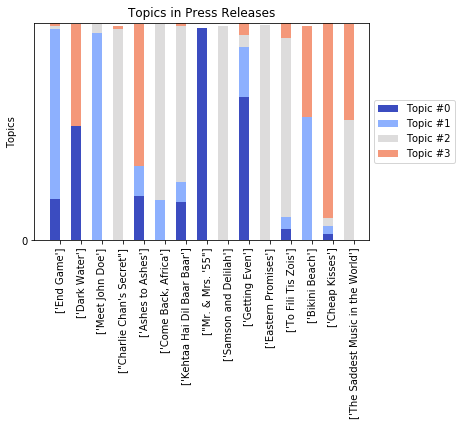

In [138]:
N = 15
ind = np.arange(N)
K = movielda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

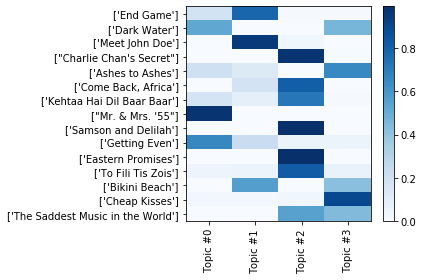

In [139]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [140]:
#Show the top 10 words in each topic
topicsDict = {}
for topicNum in range(movielda.num_topics):
    topicWords = [w for w, p in movielda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3
0,parent,jenny,parent,ho
1,su,viktor,wed,parent
2,raj,mare,sophie,wed
3,involve,ryan,catherine,vijay
4,jill,parent,involve,crow
5,andy,donna,samantha,iris
6,pooja,sonia,leo,sean
7,wed,crow,maya,involve
8,ripley,jun,ali,karan
9,amy,vampire,abby,vicky


Compared with top words list when clustering in 3 topics, we can see that there is huge difference between these words lists. When divided into four different topics, the top words are mostly "useless" human names. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [2]:
#Load soap opera texts
corpora_address = "../week-6/SOAP"
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [3]:
import zipfile
import pandas as pd

zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

soap_dict = {}
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [4]:
soap_dict.keys()

dict_keys(['All My Childen', 'As the World Turns', 'Bold and Beautiful', 'Days of Our Lives', 'General Hospital', 'Guiding Light', 'One Life to Live', 'Passions', 'Port Charles', 'Young and Restless'])

In [5]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
i = 0
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


In [6]:
soap_df

,Soap Name,Tokenized Texts
0,All My Childen,"[@!Reporter, Is, there, anything, you, regret,..."
1,As the World Turns,"[@!Katie, Okay, I, know, these, words, are, lo..."
2,Bold and Beautiful,"[@!Bridget, What, did, you, say, @!Deacon, Jus..."
3,Days of Our Lives,"[@!Maggie, How, are, you, doing, @!Victor, Fin..."
4,General Hospital,"[@!Luke, I, signed, my, divorce, papers, You, ..."
5,Guiding Light,"[@!Dax, I, take, it, everything, is, well, wit..."
6,One Life to Live,"[@!Blair, Excuse, me, @!Todd, Why, Did, you, d..."
7,Passions,"[@!Julian, Let, 's, drink, up, It, 's, not, ev..."
8,Port Charles,"[@!Frank, Hey, @!Karen, Hey, You, still, on, d..."
9,Young and Restless,"[@!Katherine, Any, sign, of, your, daddy, swee..."


In [7]:
#Change to another corpus
yar = soap_df['Tokenized Texts'][9]

In [8]:
#Present the character network in this opera
characters = {}
for token in yar:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [9]:
import networkx as nx

actor_network = nx.Graph()
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
        
i = 0
all_texts = []

for token in yar:
    i += 1
    if i > len(yar):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in yar[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(yar[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(yar[i:j]))

/Users/heatherchen/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


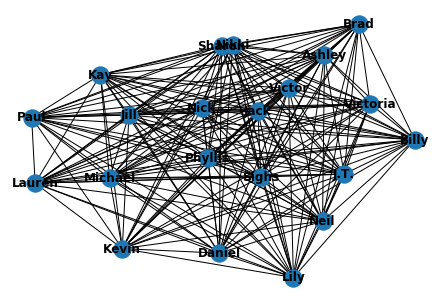

In [10]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [11]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [12]:
corpus = [dictionary.doc2bow(text) for text in all_texts]
gensim.corpora.MmCorpus.serialize('yar.mm', corpus)
yarcorpus = gensim.corpora.MmCorpus('yar.mm')

In [13]:
yarlda = gensim.models.ldamodel.LdaModel(corpus=yarcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [14]:
yarlda.show_topics()

[(0,
  '0.120*"be" + 0.074*"come" + 0.069*"want" + 0.043*"mean" + 0.040*"know" + 0.040*"talk" + 0.027*"sorry" + 0.021*"maybe" + 0.016*"home" + 0.015*"marry"'),
 (1,
  '0.221*"yes" + 0.063*"get" + 0.062*"good" + 0.035*"sure" + 0.023*"dad" + 0.021*"night" + 0.019*"idea" + 0.015*"know" + 0.015*"kid" + 0.014*"ta"'),
 (2,
  '0.062*"tell" + 0.047*"hello" + 0.026*"ask" + 0.024*"believe" + 0.024*"fine" + 0.022*"hold" + 0.020*"mom" + 0.020*"kind" + 0.018*"katherine" + 0.017*"bring"'),
 (3,
  '0.173*"oh" + 0.162*"okay" + 0.037*"baby" + 0.029*"hear" + 0.028*"god" + 0.027*"need" + 0.021*"bye" + 0.018*"little" + 0.017*"listen" + 0.014*"say"'),
 (4,
  '0.050*"mm" + 0.047*"hmm" + 0.042*"like" + 0.030*"way" + 0.025*"take" + 0.021*"stay" + 0.019*"adam" + 0.018*"phone" + 0.014*"away" + 0.014*"look"'),
 (5,
  '0.141*"uh" + 0.097*"thank" + 0.088*"hey" + 0.041*"love" + 0.033*"well" + 0.023*"huh" + 0.020*"help" + 0.019*"man" + 0.017*"guy" + 0.015*"try"'),
 (6,
  '0.138*"na" + 0.134*"gon" + 0.048*"be" + 0.03

In [15]:
#What character intend to involve in what kind of topic?
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = yarlda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

In [16]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.26467592), (1, 0.15631606), (4, 0.31877297), (5, 0.084595405), (7, 0.10284822), (9, 0.07278738)]
[(0, 0.26621813), (1, 0.15615556), (4, 0.31414077), (5, 0.08433645), (7, 0.10391624), (9, 0.07522768)]
[(0, 0.27654013), (1, 0.15115641), (4, 0.31907982), (5, 0.08006705), (7, 0.102956146), (9, 0.070192754)]
[(0, 0.2591512), (1, 0.15195818), (4, 0.3227971), (5, 0.085647225), (7, 0.10312983), (9, 0.07730895)]
[(0, 0.26200578), (1, 0.15601772), (4, 0.31319192), (5, 0.0861376), (7, 0.106228985), (9, 0.07641413)]
[(0, 0.26186207), (1, 0.15164702), (4, 0.32342058), (5, 0.08592477), (7, 0.10147964), (9, 0.07565887)]
[(0, 0.27328572), (1, 0.15023589), (4, 0.31347272), (5, 0.085060045), (7, 0.10245839), (9, 0.07548211)]
[(0, 0.27109456), (1, 0.15517576), (4, 0.31558797), (5, 0.08416611), (7, 0.102444716), (9, 0.07152772)]
[(0, 0.262721), (1, 0.15255828), (4, 0.32058156), (5, 0.085335866), (7, 0.104805894), (9, 0.07399331)]
[(0, 0.2656644), (1, 0.1544062), (4, 0.31866395), (5, 0.087077744), (

It seems that every character is equally involved in the 10 topics derived. 